In [25]:
import warnings
warnings.filterwarnings('ignore')

In [26]:
import joblib  
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

In [27]:
def detecter_delimiteur(chemin_fichier):
    """
    Détecter le délimiteur utilisé dans un fichier CSV.
    """
    with open(chemin_fichier, 'r') as f:
        ligne = f.readline()
        delimiteurs_possibles = [',', ';', '\t', '|']
        return max(delimiteurs_possibles, key=ligne.count)

def classifier_billets(chemin_csv, chemin_modele):
    try:
        # Charger le modèle sauvegardé
        modele_charge = joblib.load(chemin_modele)

        # Détecter le délimiteur utilisé dans le fichier CSV
        delimiteur_detecte = detecter_delimiteur(chemin_csv)

        # Charger le fichier CSV
        donnees = pd.read_csv(chemin_csv, delimiter=delimiteur_detecte)

        # Vérifier les valeurs manquantes et les supprimer
        donnees.dropna(inplace=True)

        # Sélection des colonnes à utiliser pour la prédiction
        num_cols = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']
        donnees_a_predire = donnees[num_cols]

        # Standardiser les colonnes numériques
        scaler = StandardScaler()
        donnees_normalisees = scaler.fit_transform(donnees_a_predire)

        # Utiliser le modèle chargé pour faire des prédictions
        predictions = modele_charge.predict(donnees_normalisees)

        # Ajout colonne résultat
        donnees.loc[donnees.index, 'Resultat'] = predictions

        # Remplacement 0 par Faux et 1 par Vrai (suivant paramétrage du modèle du premier notebook)
        donnees['Resultat'].replace([0,1], ['Faux','Vrai'], inplace=True)

        # Ajout d'une colonne de probabilité pour chaque billet
        donnees['Probabilite'] = (modele_charge.predict_proba(donnees_normalisees)[:,1] * 100).round(2)

        display(donnees)
        print('\n \n Graph PieChart : ')


        # Compter le nombre de prédictions Vrai et Faux
        uniques, comptes = np.unique(predictions, return_counts=True)
        comptes_predictions = dict(zip(uniques, comptes))

         # Préparer les données pour le graphique en camembert
        etiquettes = ['Authentique', 'Faux']
        tailles = [comptes_predictions.get(1, 0), comptes_predictions.get(0, 0)]
        couleurs = ['green', 'red']
        
        # Paramètre pour "exploser" le camembert
        explode = (0, 0.08)  # Seule la seconde portion du camembert (Faux) sera "explosée"

        # Tracer le graphique en camembert
        fig1, ax1 = plt.subplots()
        wedges, texts, autotexts = ax1.pie(tailles, explode=explode, labels=etiquettes, autopct=lambda p: f"{p:.1f}% ({int(p * sum(tailles) / 100)})",
                                            startangle=90, colors=couleurs, shadow=True)

        # Configuration des labels et du titre
        plt.setp(autotexts, size=10, weight="bold", color="white")
        ax1.axis('equal')
        plt.title('Classification des Billets')

        # Ajouter une légende
        plt.legend(etiquettes, title="Légende")

        plt.show()
        return "Classification réussie"
    except Exception as e:
        return str(e)



,diagonal,height_left,height_right,margin_low,margin_up,length,id,Resultat,Probabilite
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1,Faux,3.53
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2,Faux,1.04
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3,Faux,0.50
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4,Vrai,99.98
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5,Vrai,100.00



 
 Graph PieChart : 


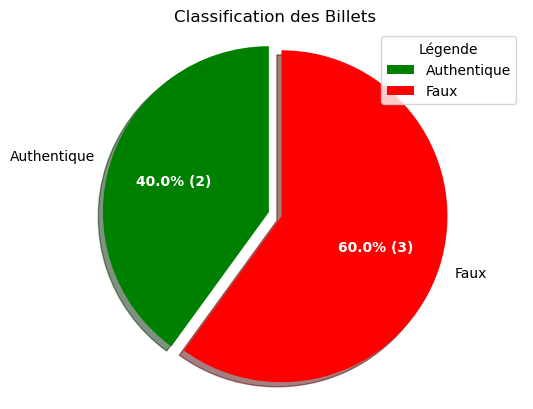

'Classification réussie'

In [28]:
# Tester la fonction mise à jour avec les données existantes et le modèle sauvegardé
model_filename = "model_final_.pkl"  # Remplacez par le nom de votre fichier modèle
classifier_billets('billets_production.csv', model_filename)  # Remplacez 'votre_fichier.csv' par le chemin de votre fichier CSV
